[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture6_spectral_concentration.ipynb)

# CS 294-92: Lecture 6 - Spectral Concentration and Low-Degree Learning

**Instructor:** Avishay Tal  
**Scribe & Notebook by:** Gabriel Taboada  
**Reference:** O'Donnell, *Analysis of Boolean Functions*, Chapter 3

---

## Overview

This notebook explores the connection between Boolean function analysis and learning theory:

1. **Spectral Concentration**: When is a function's Fourier weight concentrated on low-degree coefficients?
2. **Decision Trees**: How decision tree depth relates to spectral concentration
3. **PAC Learning**: The LMN Theorem for learning functions with spectral concentration
4. **Fourier Coefficient Estimation**: Using samples to estimate Fourier coefficients

---

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


BooFun version: 1.1.1


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis import learning, complexity

import warnings
warnings.filterwarnings('ignore')

## 1. Spectral Concentration

**Definition:** A function $f$ is **$\varepsilon$-concentrated** on degree $\leq k$ if:
$$\mathbf{W}^{>k}[f] := \sum_{|S| > k} \hat{f}(S)^2 \leq \varepsilon$$

This means the "Fourier weight" on high-degree coefficients is small.

### Example: Decision Trees and Spectral Concentration

**Theorem (O'Donnell 3.2):** A depth-$d$ decision tree has all its Fourier mass on degree $\leq d$.

In [3]:
# Demonstrate spectral concentration for different functions
functions = [
    ("Dictator x₀", bf.dictator(4, 0)),    # 4 vars, dictator index 0, depth 1
    ("Majority-5", bf.majority(5)),         # Complex
    ("Parity-4", bf.parity(4)),             # Max degree
    ("Tribes(2,3)", bf.tribes(2, 3)),       # DNF
]

print("Spectral Concentration Analysis")
print("=" * 70)
print(f"{'Function':<15} {'DT depth':>10} {'W≤1':>10} {'W≤2':>10} {'W≤3':>10}")
print("-" * 70)

for name, f in functions:
    dt_depth = complexity.decision_tree_depth(f)
    
    # f.W_leq(k) = sum of f̂(S)² for |S| ≤ k
    conc = [f.W_leq(k) for k in [1, 2, 3]]
    
    print(f"{name:<15} {dt_depth:>10} {conc[0]:>10.4f} {conc[1]:>10.4f} {conc[2]:>10.4f}")

print("\nHigher DT depth → spectral weight spreads to higher degrees")

Spectral Concentration Analysis
Function          DT depth        W≤1        W≤2        W≤3
----------------------------------------------------------------------
Dictator x₀              1     1.0000     1.0000     1.0000
Majority-5               5     0.7031     0.7031     0.8594
Parity-4                 4     0.0000     0.0000     0.0000
Tribes(2,3)              3     0.7500     0.9375     1.0000

Higher DT depth → spectral weight spreads to higher degrees


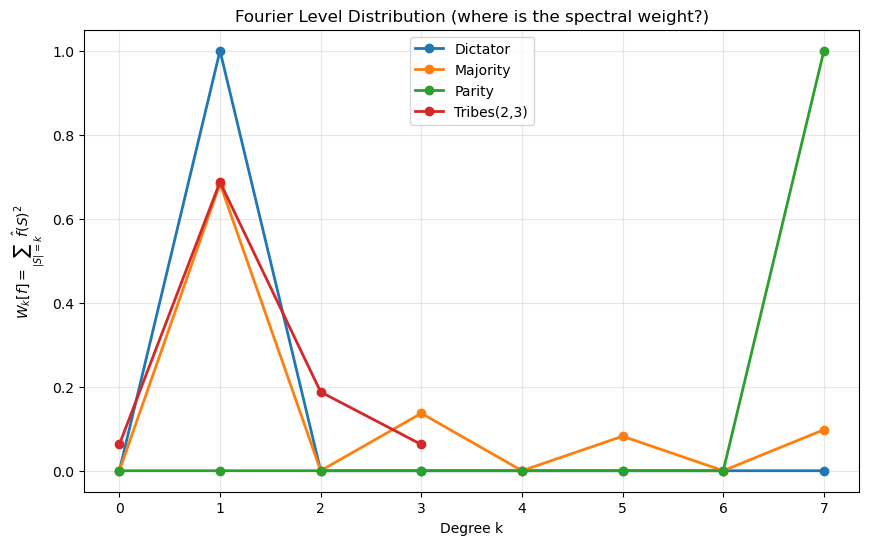

Observations:
  Dictator:  All weight at degree 1
  Parity:    All weight at degree n (maximally high-degree)
  Majority:  Weight spread across odd degrees, concentrated on low degrees
  Tribes:    Mostly low-degree (DNF structure)


In [4]:
# Visualize Fourier level distribution (W_k = sum of f̂(S)² for |S|=k)
# This shows how spectral weight is distributed across degrees

n = 7
functions = {
    "Dictator": bf.dictator(n, 0),
    "Majority": bf.majority(n),
    "Parity": bf.parity(n),
    "Tribes(2,3)": bf.tribes(2, n // 2) if n >= 4 else bf.AND(n),
}

fig, ax = plt.subplots(figsize=(10, 6))

for name, f in functions.items():
    fourier = f.fourier()
    # Compute W_k for each degree k
    W_k = [0.0] * (f.n_vars + 1)
    for s in range(len(fourier)):
        degree = bin(s).count('1')
        W_k[degree] += fourier[s] ** 2
    
    ax.plot(range(len(W_k)), W_k, 'o-', label=name, linewidth=2, markersize=6)

ax.set_xlabel('Degree k')
ax.set_ylabel('$W_k[f] = \\sum_{|S|=k} \\hat{f}(S)^2$')
ax.set_title('Fourier Level Distribution (where is the spectral weight?)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(range(n + 1))
plt.show()

print("Observations:")
print("  Dictator:  All weight at degree 1")
print("  Parity:    All weight at degree n (maximally high-degree)")
print("  Majority:  Weight spread across odd degrees, concentrated on low degrees")
print("  Tribes:    Mostly low-degree (DNF structure)")

---
## 2. Fourier Coefficient Estimation

**Lemma (O'Donnell 3.30):** Given $m = O(\log(1/\delta)/\varepsilon^2)$ samples, we can estimate $\hat{f}(S)$ with error $\leq \varepsilon$ with probability $\geq 1 - \delta$.

The empirical estimator is:
$$\tilde{f}(S) = \frac{1}{m} \sum_{i=1}^{m} f(x^{(i)}) \chi_S(x^{(i)})$$

In [5]:
# Demonstrate Fourier coefficient estimation using the library's built-in function
from boofun.analysis.learning import estimate_fourier_coefficient

f = bf.majority(4)
true_coeffs = f.fourier()
sample_sizes = [50, 200, 1000]

print("Fourier Coefficient Estimation (Majority-4)")
print("=" * 75)
print(f"{'Subset S':<10} {'True':>8} " + "".join(f"{'m='+str(m)+' (est±stderr)':>20}" for m in sample_sizes))
print("-" * 75)

# Important: use DIFFERENT random seeds for each sample size to get independent estimates
subsets_to_show = [0, 1, 2, 3, 5, 15]  # Empty, singletons, pairs, full

for s in subsets_to_show:
    subset = [i for i in range(4) if (s >> i) & 1]
    true_val = true_coeffs[s]
    row = f"{str(subset):<10} {true_val:>8.4f}"
    
    for i, m in enumerate(sample_sizes):
        # Use different seed for each sample size to get independent samples
        rng = np.random.default_rng(42 + i * 1000 + s)
        est, stderr = estimate_fourier_coefficient(f, s, num_samples=m, rng=rng)
        row += f" {est:>9.4f}±{stderr:.4f}"
    
    print(row)

print("\nStandard error decreases as 1/√m (more samples → better estimates)")

Fourier Coefficient Estimation (Majority-4)
Subset S       True    m=50 (est±stderr)  m=200 (est±stderr) m=1000 (est±stderr)
---------------------------------------------------------------------------
[]           0.3750    0.2400±0.1387    0.4200±0.0643    0.3880±0.0292
[0]          0.3750    0.6800±0.1047    0.3400±0.0667    0.3320±0.0298
[1]          0.3750    0.2800±0.1371    0.4600±0.0629    0.3640±0.0295
[0, 1]      -0.1250   -0.0800±0.1424   -0.2200±0.0692   -0.0980±0.0315
[0, 2]      -0.1250   -0.3200±0.1353   -0.1100±0.0705   -0.1100±0.0314
[0, 1, 2, 3]   0.3750    0.2800±0.1371    0.4100±0.0647    0.3100±0.0301

Standard error decreases as 1/√m (more samples → better estimates)


---
## 3. The LMN Theorem (PAC Learning)

**Theorem (Linial-Mansour-Nisan, 1993):** 
Let $\mathcal{C}$ be a concept class such that every $f \in \mathcal{C}$ is $\varepsilon$-concentrated on Fourier coefficients of degree $\leq k$.
Then $\mathcal{C}$ is $(\varepsilon, \delta)$-PAC learnable in time $\text{poly}(n^k, 1/\varepsilon, \log(1/\delta))$.

### Learning Algorithm

1. Estimate all degree-$\leq k$ Fourier coefficients using samples
2. Construct hypothesis: $h(x) = \text{sgn}\left(\sum_{|S| \leq k} \tilde{f}(S) \chi_S(x)\right)$
3. Fourier concentration bounds the approximation error

In [6]:
# Demonstrate the LMN learning algorithm (simplified version)
from boofun.analysis.learning import estimate_fourier_coefficient

# Create a depth-2 decision tree: (x₀ AND x₁) OR (x₂ AND x₃)
# Truth table: f=1 when (x₀=1 and x₁=1) or (x₂=1 and x₃=1)
tt = []
for i in range(16):
    x0, x1, x2, x3 = [(i >> j) & 1 for j in range(4)]
    val = (x0 and x1) or (x2 and x3)
    tt.append(val)
target = bf.create(tt)

print("LMN Learning Example")
print("=" * 60)
print("Target: (x₀ AND x₁) OR (x₂ AND x₃)")
print(f"Decision tree depth: {complexity.decision_tree_depth(target)}")
print()

# Show spectral concentration: W≤k = sum of f̂(S)² for |S| ≤ k
for k in [1, 2, 3, 4]:
    conc = target.W_leq(k)
    print(f"W≤{k} = {conc:.4f}")

print("\nLMN approach: estimate low-degree coefficients, threshold to classify")

# Estimate degree ≤ 2 coefficients
rng = np.random.default_rng(42)
estimated_coeffs = {}
for s in range(16):
    degree = bin(s).count('1')
    if degree <= 2:
        est, _ = estimate_fourier_coefficient(target, s, num_samples=500, rng=rng)
        if abs(est) > 0.05:
            estimated_coeffs[s] = est

print(f"\nEstimated {len(estimated_coeffs)} non-negligible degree-≤2 coefficients")

# Use estimated coefficients for prediction
def predict(x):
    val = sum(coeff * (1 - 2 * (bin(x & s).count('1') % 2)) 
              for s, coeff in estimated_coeffs.items())
    return 1 if val > 0 else -1

# Test accuracy
correct = sum(1 for x in range(16) 
              if predict(x) == (1 - 2 * int(target.evaluate(x))))

print(f"Learning accuracy: {correct}/16 = {correct/16:.2%}")

LMN Learning Example
Target: (x₀ AND x₁) OR (x₂ AND x₃)
Decision tree depth: 4

W≤1 = 0.5781
W≤2 = 0.9219
W≤3 = 0.9844
W≤4 = 1.0000

LMN approach: estimate low-degree coefficients, threshold to classify

Estimated 11 non-negligible degree-≤2 coefficients
Learning accuracy: 16/16 = 100.00%


---
## 4. The Goldreich-Levin Algorithm

**Problem:** Find all "heavy" Fourier coefficients without enumerating all $2^n$ subsets.

**Theorem (Goldreich-Levin, 1989):** There exists an algorithm that, given oracle access to $f$, finds all $S$ with $|\hat{f}(S)| \geq \tau$ using $O(n/\tau^4)$ queries.

### Key Idea: Self-Correction via Restrictions

For a random subset $T \subseteq [n]$:
$$\mathbf{E}_{T,b}[\hat{f|_{T=b}}(S|_{\bar{T}})] = \hat{f}(S)$$

This allows recursively finding heavy coefficients by restricting variables.

In [7]:
# Demonstrate Goldreich-Levin algorithm on multiple functions
from boofun.analysis.learning import goldreich_levin

test_functions = {
    "Parity-4": bf.parity(4),
    "Majority-5": bf.majority(5),
    "Dictator": bf.dictator(4, 0),
    "AND-4": bf.AND(4),
}

for name, f in test_functions.items():
    print(f"Goldreich-Levin on {name}")
    print("=" * 50)
    
    # True heavy coefficients
    true_coeffs = f.fourier()
    true_heavy = [(s, c) for s, c in enumerate(true_coeffs) if abs(c) > 0.1]
    
    print(f"True heavy coefficients (|f̂(S)| > 0.1): {len(true_heavy)}")
    for s, c in true_heavy[:3]:  # Show first 3
        subset = [i for i in range(f.n_vars) if (s >> i) & 1]
        print(f"  S={subset}: f̂(S) = {c:.4f}")
    if len(true_heavy) > 3:
        print(f"  ... and {len(true_heavy) - 3} more")
    
    # Use Goldreich-Levin
    heavy = goldreich_levin(f, threshold=0.2)
    print(f"\nGL found {len(heavy)} coefficient(s)")
    print()

Goldreich-Levin on Parity-4
True heavy coefficients (|f̂(S)| > 0.1): 1
  S=[0, 1, 2, 3]: f̂(S) = 1.0000

GL found 1 coefficient(s)

Goldreich-Levin on Majority-5
True heavy coefficients (|f̂(S)| > 0.1): 16
  S=[0]: f̂(S) = 0.3750
  S=[1]: f̂(S) = 0.3750
  S=[2]: f̂(S) = 0.3750
  ... and 13 more



GL found 8 coefficient(s)

Goldreich-Levin on Dictator
True heavy coefficients (|f̂(S)| > 0.1): 1
  S=[0]: f̂(S) = 1.0000

GL found 1 coefficient(s)

Goldreich-Levin on AND-4
True heavy coefficients (|f̂(S)| > 0.1): 16
  S=[]: f̂(S) = 0.8750
  S=[0]: f̂(S) = 0.1250
  S=[1]: f̂(S) = 0.1250
  ... and 13 more

GL found 2 coefficient(s)



---
## Summary

### Key Concepts

1. **Spectral Concentration**: Functions with bounded decision tree depth have Fourier weight concentrated on low degrees

2. **LMN Theorem**: If a function class has spectral concentration at degree $k$, it's PAC-learnable in time $n^{O(k)}$

3. **Fourier Coefficient Estimation**: $O(\log(1/\delta)/\varepsilon^2)$ samples suffice to estimate any $\hat{f}(S)$ within $\varepsilon$

4. **Goldreich-Levin**: Find heavy Fourier coefficients efficiently without enumeration

### Corollaries (from lecture notes)

- **Depth-d decision trees**: Learnable in time $n^{O(d)}$
- **Size-s decision trees**: Learnable in time $n^{O(\log s)}$
- **Linear Threshold Functions**: Learnable in time $n^{O(1/\varepsilon^2)}$

### boofun API

```python
from boofun.analysis.learning import estimate_fourier_coefficient, goldreich_levin
from boofun.analysis.pac_learning import pac_learn_low_degree

# Estimate single coefficient
est, stderr = estimate_fourier_coefficient(f, S, num_samples=1000)

# Find all heavy coefficients
heavy = goldreich_levin(f, threshold=0.1)

# PAC learn with low-degree assumption
coeffs = pac_learn_low_degree(f, max_degree=3, epsilon=0.1)
```

### Open Questions

- Can depth-$d$ decision trees be learned in $\text{poly}(n, 2^d)$ time?
- Can $k$-juntas be learned in $\text{poly}(n)$ time for $k = \log n$?
- Efficient learning of small DNF/CNF formulas?